In [45]:
# =============================================================================
# 1. IMPORTS & DATA LOADING
# =============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import os
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
from xgboost import XGBRegressor

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
def scrape_acsi_live():
    """
    Scrapes ACSI satisfaction scores from their website.
    Returns a dataframe with brand names and their 2024 scores.
    """
    url = "https://theacsi.org/industries/manufacturing/personal-computers/"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36",
        "Referer": "https://www.google.com/"
    }
    try:
        print(f"Fetching data from {url}...")
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        table = None
        for t in soup.find_all('table'):
            table_text = t.get_text()
            if "Apple" in table_text and "HP" in table_text:
                table = t
                break
        if not table:
            print("Couldn't find the ACSI table on the page.")
            return None
        data = []
        for row in table.find_all('tr'):
            cells = row.find_all('td')
            if len(cells) >= 4:
                brand_name = cells[1].get_text(strip=True)
                score_2024 = cells[2].get_text(strip=True)

                if brand_name:
                    data.append({
                        'Brand': brand_name,
                        'ACSI_2024': score_2024
                    })
        df_acsi = pd.DataFrame(data)
        df_acsi['ACSI_2024'] = pd.to_numeric(df_acsi['ACSI_2024'], errors='coerce')
        return df_acsi
    except Exception as e:
        print(f"Error scraping ACSI data: {e}")
        return None
df_live = scrape_acsi_live()
if df_live is not None:
    df_live['brand_lower'] = df_live['Brand'].str.lower()
    acsi_map = df_live.set_index('brand_lower')['ACSI_2024'].to_dict()
    default_acsi = df_live['ACSI_2024'].mean()
    print("Successfully loaded ACSI data.")
else:
    acsi_map = {}
    default_acsi = 79
    print("Couldn't get live data using fallback values.")

Fetching data from https://theacsi.org/industries/manufacturing/personal-computers/...
Successfully loaded ACSI data.


In [47]:
csv_file_path = "/content/drive/MyDrive/computer_prices_all (2).csv"

df = pd.read_csv(csv_file_path)
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
cols_needed = [
    'brand', 'os', 'device_type', 'ram_gb', 'storage_type',
    'display_size_in', 'resolution', 'refresh_hz',
    'cpu_brand', 'gpu_brand', 'gpu_model', 'weight_kg', 'release_year', 'price'
]
existing_cols = [c for c in cols_needed if c in df.columns]
df = df[existing_cols].dropna()
price_cap = df['price'].quantile(0.95)
df = df[df['price'] < price_cap].copy()
print(f"After filtering: {df.shape[0]} rows (price capped at ${price_cap:.2f})")

Loaded dataset with 100000 rows and 33 columns
After filtering: 94995 rows (price capped at $2956.99)


In [48]:
# ==========================================
# 2. THE PURGE (Clean Rows FIRST)
# ==========================================
price_cap = df['price'].quantile(0.95)
df = df[df['price'] < price_cap]
df = df[~((df['ram_gb'] > 64) & (df['price'] < 2000))]
df = df[df['ram_gb'] >= 4]

def is_fake_gaming(row):
    gpu_txt = str(row.get('gpu_brand', '')).lower()
    if ('nvidia' in gpu_txt or 'rtx' in gpu_txt) and row['price'] < 400:
        return 1
    return 0
df = df[df.apply(is_fake_gaming, axis=1) == 0]
print(f"After cleanup: {df.shape[0]} rows remaining")

After cleanup: 89442 rows remaining


In [49]:
# ==========================================
# 3. FEATURE ENGINEERING
# ==========================================

default_acsi = 78
acsi_map = {'apple': 87, 'samsung': 82, 'dell': 81, 'hp': 80}

df['brand_reputation'] = df['brand'].str.lower().map(acsi_map).fillna(default_acsi)
def get_gpu_tier(row):
    txt = (str(row.get('gpu_brand', '')) + " " + str(row.get('gpu_model', ''))).lower()

    if any(x in txt for x in ['4090', '4080', '3090', '3080', 'm3 max', 'm2 max']):
        return 3
    elif any(x in txt for x in ['4070', '4060', '3070', '3060', '2080', 'm3 pro', 'm2 pro']):
        return 2
    elif any(x in txt for x in ['rtx', 'gtx', 'rx', 'arc', 'dedicated']):
        return 1
    else:
        return 0
df['gpu_tier'] = df.apply(get_gpu_tier, axis=1)
try:
    res_split = df['resolution'].str.split('x', expand=True).astype(float)
    w, h = res_split[0], res_split[1]

    df['ppi'] = np.sqrt(w**2 + h**2) / df['display_size_in'].replace(0, np.nan)
    df['ppi'] = df['ppi'].fillna(0)

    print("PPI calculated successfully.")
except Exception as e:
    print(f"Couldn't calculate PPI: {e}")
    df['ppi'] = 0

df['log_price'] = np.log(df['price'])

PPI calculated successfully.


Encoding columns: ['brand', 'os', 'device_type', 'storage_type']
Total features after encoding: 25
Data ready


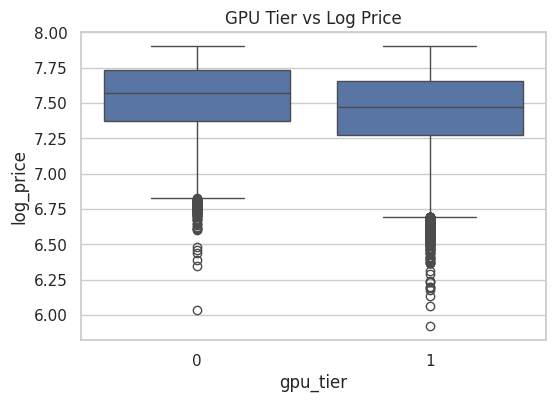

In [50]:
# ==========================================
# 4. PREPARE FOR MODELING
# ==========================================
cols_to_drop = [
    'price',
    'resolution',
    'gpu_brand',
    'gpu_model',
    'cpu_brand'
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Encoding columns: {cat_cols}")

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(f"Total features after encoding: {df_encoded.shape[1]}")
# ==========================================
# 5. SPLIT & EVALUATION SETUP
# ==========================================

X = df_encoded.drop('log_price', axis=1)
y = df_encoded['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data ready")

plt.figure(figsize=(6, 4))
sns.boxplot(x='gpu_tier', y='log_price', data=df)
plt.title('GPU Tier vs Log Price')
plt.show()

Re-calculated 'price' column for visualization.

--- Visualizing Cleaned Data Patterns ---


/tmp/ipython-input-3720540353.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gpu_tier', y='price', data=df, ax=axes[0, 1], palette='viridis')
/tmp/ipython-input-3720540353.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='brand', y='price', data=df[df['brand'].isin(top_brands)],
/tmp/ipython-input-3720540353.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)


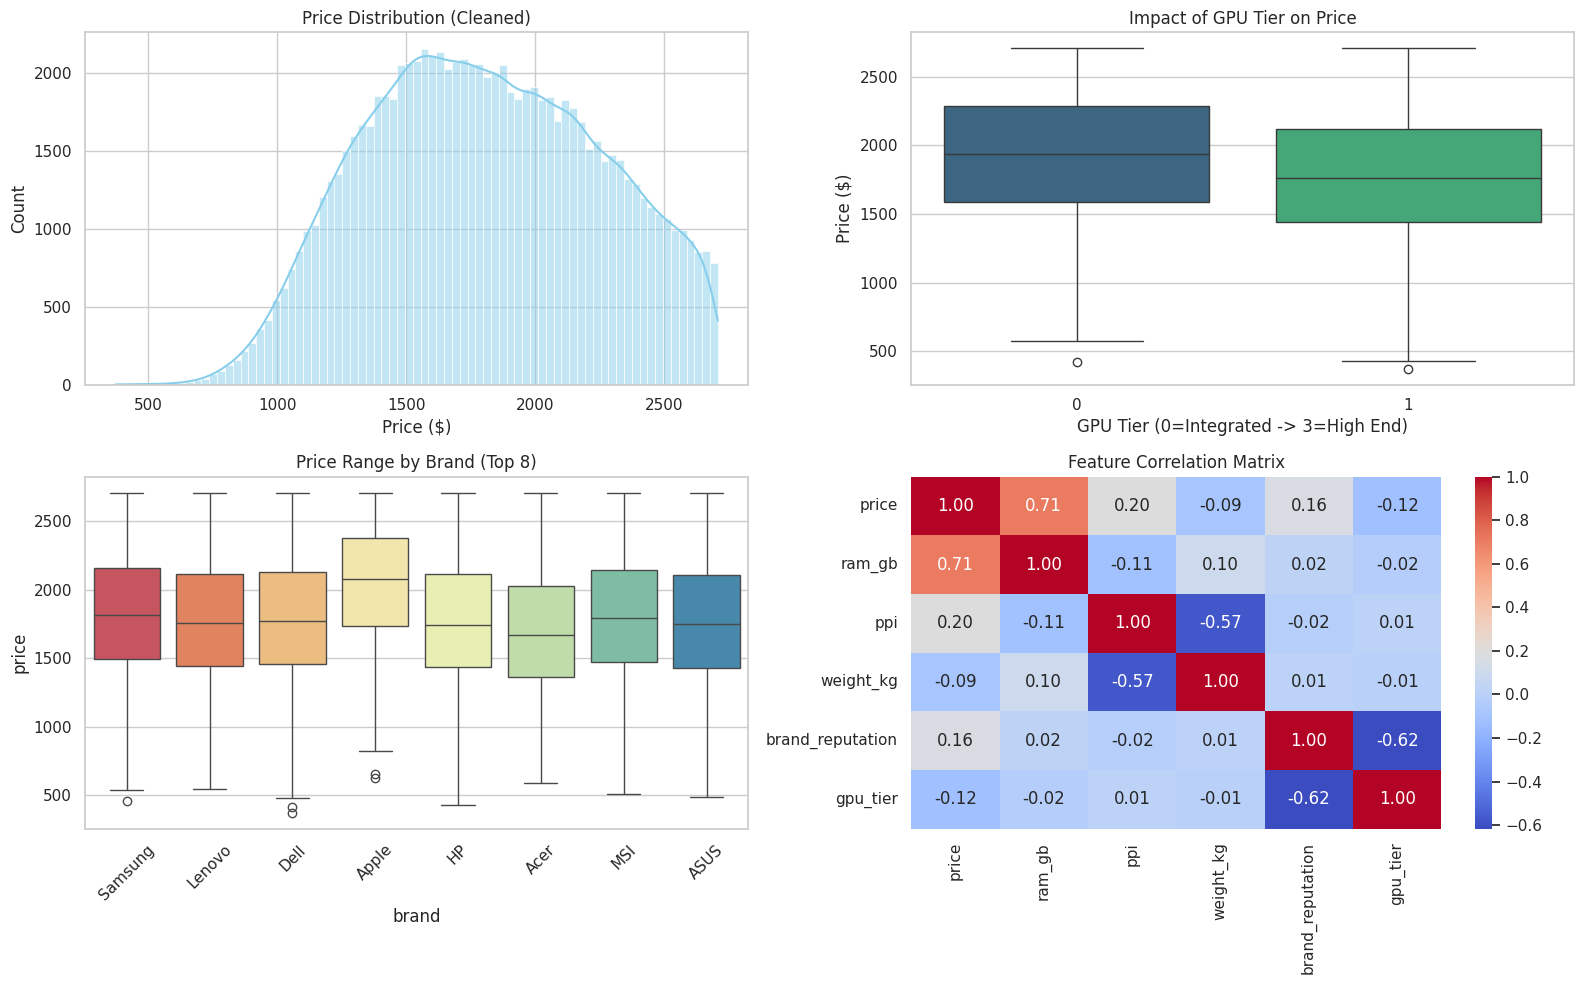

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if 'price' not in df.columns and 'log_price' in df.columns:
    df['price'] = np.exp(df['log_price'])
    print("Re-calculated 'price' column for visualization.")

print("\n--- Visualizing Cleaned Data Patterns ---")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.histplot(df['price'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Price Distribution (Cleaned)')
axes[0, 0].set_xlabel('Price ($)')

if 'gpu_tier' in df.columns:
    sns.boxplot(x='gpu_tier', y='price', data=df, ax=axes[0, 1], palette='viridis')
    axes[0, 1].set_title('Impact of GPU Tier on Price')
    axes[0, 1].set_xlabel('GPU Tier (0=Integrated -> 3=High End)')
    axes[0, 1].set_ylabel('Price ($)')
else:
    axes[0, 1].text(0.5, 0.5, "gpu_tier column not found", ha='center', va='center')

if 'brand' in df.columns:
    top_brands = df['brand'].value_counts().head(8).index
    sns.boxplot(x='brand', y='price', data=df[df['brand'].isin(top_brands)],
                ax=axes[1, 0], palette='Spectral')
    axes[1, 0].set_title('Price Range by Brand (Top 8)')
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
else:
    axes[1, 0].text(0.5, 0.5, "brand column not found", ha='center', va='center')

possible_cols = ['price', 'ram_gb', 'ppi', 'weight_kg', 'brand_reputation', 'gpu_tier']
existing_cols = [c for c in possible_cols if c in df.columns]

if len(existing_cols) > 1:
    corr = df[existing_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1, 1])
    axes[1, 1].set_title('Feature Correlation Matrix')
else:
    axes[1, 1].text(0.5, 0.5, "Not enough numeric columns for heatmap",
                    ha='center', va='center')

plt.tight_layout()
plt.show()

In [ ]:
df_encoded.head()


,ram_gb,display_size_in,refresh_hz,weight_kg,release_year,brand_reputation,gpu_tier,ppi,log_price,brand_Acer,brand_Apple,brand_Dell,brand_Gigabyte,brand_HP,brand_Lenovo,brand_MSI,brand_Razer,brand_Samsung,os_Linux,os_Windows,os_macOS,device_type_Laptop,storage_type_Hybrid,storage_type_NVMe,storage_type_SSD
0,16,27.0,90,11.00,2022,82.0,1,108.785539,7.232726,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False
1,64,16.0,90,2.03,2022,82.0,1,137.681698,7.729731,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False
2,8,32.0,120,7.00,2024,78.0,1,116.538620,7.539022,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,16,27.0,120,6.00,2024,81.0,1,138.119846,7.194429,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
4,96,15.6,90,1.50,2024,78.0,1,193.517562,7.894314,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False



=== STEP 4: STATISTICAL HYPOTHESIS TESTING ===
Objective: Prove that GPU Tier and RAM have a statistically significant impact on Price.

--- Hypothesis 1: GPU Tier vs Price ---
F-Statistic: 1213.05
P-Value:     5.2772e-264
>> RESULT: REJECT Null Hypothesis. GPU Tier significantly impacts Price. (Good feature!)

--- Hypothesis 2: RAM vs Price ---
Correlation: 0.6750 (1.0 is perfect correlation)
P-Value:     0.0000e+00
>> RESULT: REJECT Null Hypothesis. RAM quantity is linked to Price. (Good feature!)

--- Hypothesis 3: Apple Brand vs Price ---
T-Statistic: 58.28
P-Value:     0.0000e+00
>> RESULT: REJECT Null Hypothesis. The 'Apple Tax' is statistically real.


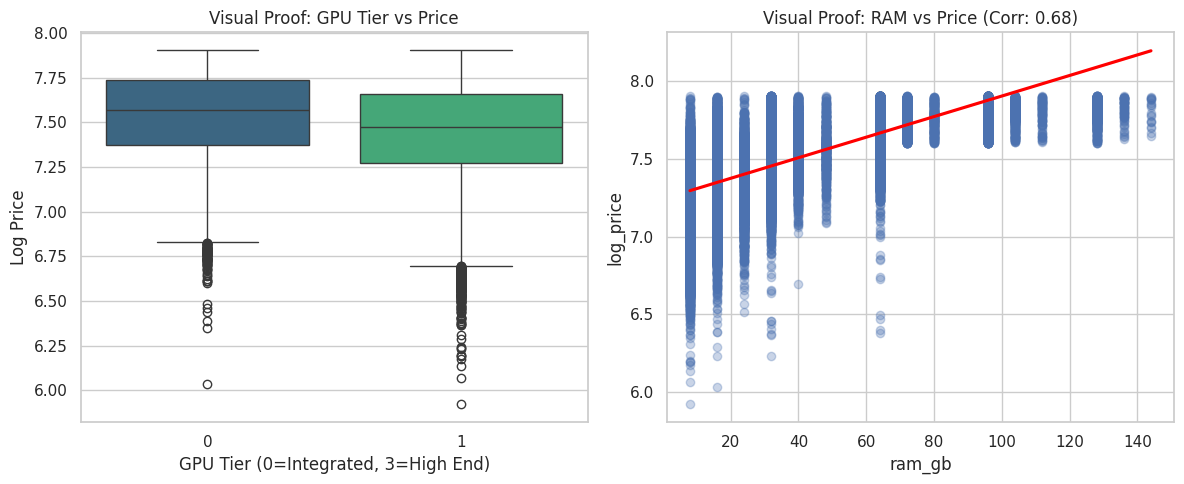


(If P-Values are < 0.05, we are scientifically cleared to proceed to modeling.)


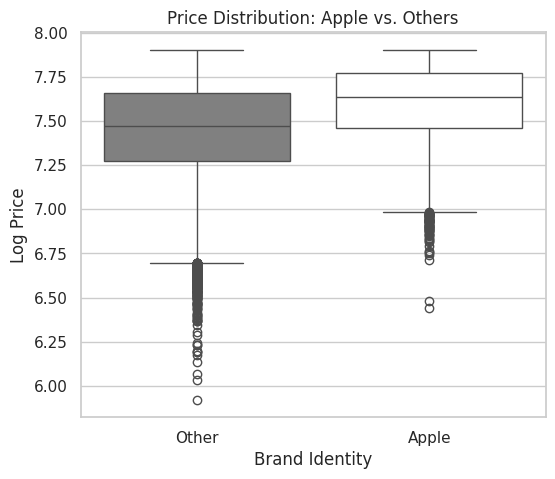

In [52]:
from scipy import stats

# ==========================================
# 4. HYPOTHESIS TESTING (Scientific Proof)
# ==========================================
print("\n=== STEP 4: STATISTICAL HYPOTHESIS TESTING ===")
print("Objective: Prove that GPU Tier and RAM have a statistically significant impact on Price.\n")

groups = []
for tier in sorted(df['gpu_tier'].unique()):
    groups.append(df[df['gpu_tier'] == tier]['log_price'])

f_stat, p_value_gpu = stats.f_oneway(*groups)

print(f"--- Hypothesis 1: GPU Tier vs Price ---")
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value:     {p_value_gpu:.4e}")

if p_value_gpu < 0.05:
    print(">> RESULT: REJECT Null Hypothesis. GPU Tier significantly impacts Price. (Good feature!)")
else:
    print(">> RESULT: FAIL to reject. GPU Tier might not matter.")


corr_coef, p_value_ram = stats.pearsonr(df['ram_gb'], df['log_price'])

print(f"\n--- Hypothesis 2: RAM vs Price ---")
print(f"Correlation: {corr_coef:.4f} (1.0 is perfect correlation)")
print(f"P-Value:     {p_value_ram:.4e}")

if p_value_ram < 0.05:
    print(">> RESULT: REJECT Null Hypothesis. RAM quantity is linked to Price. (Good feature!)")
else:
    print(">> RESULT: FAIL to reject. RAM might not matter.")

print(f"\n--- Hypothesis 3: Apple Brand vs Price ---")

if 'brand_Apple' in df.columns:
    apple_prices = df[df['brand_Apple'] == 1]['log_price']
    non_apple_prices = df[df['brand_Apple'] == 0]['log_price']
else:
    apple_prices = df[df['brand'] == 'Apple']['log_price']
    non_apple_prices = df[df['brand'] != 'Apple']['log_price']

t_stat, p_value_apple = stats.ttest_ind(apple_prices, non_apple_prices, equal_var=False)

print(f"T-Statistic: {t_stat:.2f}")
print(f"P-Value:     {p_value_apple:.4e}")

if p_value_apple < 0.05:
    print(">> RESULT: REJECT Null Hypothesis. The 'Apple Tax' is statistically real.")
else:
    print(">> RESULT: FAIL to reject. No significant price difference found.")



# ==========================================
# VISUAL PROOF
# ==========================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='gpu_tier', y='log_price', data=df, hue='gpu_tier', legend=False, palette='viridis')
plt.title('Visual Proof: GPU Tier vs Price')
plt.xlabel('GPU Tier (0=Integrated, 3=High End)')
plt.ylabel('Log Price')

plt.subplot(1, 2, 2)
sns.regplot(x='ram_gb', y='log_price', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title(f'Visual Proof: RAM vs Price (Corr: {corr_coef:.2f})')

plt.tight_layout()
plt.show()

print("\n(If P-Values are < 0.05, we are scientifically cleared to proceed to modeling.)")
plt.figure(figsize=(6, 5))
df['Is_Apple'] = df['brand_Apple'].apply(lambda x: 'Apple' if x==1 else 'Other') if 'brand_Apple' in df.columns else df['brand'].apply(lambda x: 'Apple' if x=='Apple' else 'Other')

sns.boxplot(x='Is_Apple', y='log_price', data=df, hue='Is_Apple', palette=['gray', 'white'])
plt.title('Price Distribution: Apple vs. Others')
plt.xlabel('Brand Identity')
plt.ylabel('Log Price')
plt.show()

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# ==========================================
# 0. EVALUATION TOOLKIT
# ==========================================
model_performance = []
def evaluate_and_log(model, X_test, y_test_log, model_name):
    """
    1. Predicts in Log Scale
    2. Converts back to Dollars ($)
    3. Calculates MAE/RMSE/R2
    4. Logs result
    """
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_test_log)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"MAE:  ${mae:.2f}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"R²:   {r2:.4f}\n")
    model_performance.append({
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })
    return y_pred
# ==========================================
# 1. MODEL 1: RIDGE REGRESSION (Baseline)
# ==========================================
print("--- Training Model 1: Ridge (Baseline) ---")
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
_ = evaluate_and_log(ridge, X_test, y_test, "Ridge Regression")
# ==========================================
# 2. MODEL 2: RANDOM FOREST (Restored)
# ==========================================
print("--- Training Model 2: Random Forest ---")
rf_params = {
    'n_estimators': [100],
    'max_depth': [20, None],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    cv=3,
    n_jobs=2,
    verbose=0
)
grid_rf.fit(X_train, y_train)
print(f"Best RF Params: {grid_rf.best_params_}")

best_rf = grid_rf.best_estimator_
_ = evaluate_and_log(best_rf, X_test, y_test, "Random Forest (Tuned)")

--- Training Model 1: Ridge (Baseline) ---
--- Ridge Regression ---
MAE:  $214.43
RMSE: $272.59
R²:   0.6237

--- Training Model 2: Random Forest ---


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF Params: {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 100}
--- Random Forest (Tuned) ---
MAE:  $181.17
RMSE: $228.61
R²:   0.7354



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
print("--- Starting Hyperparameter Search (This may take 2-3 minutes) ---")
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05,0.03, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6,0.7, 0.8, 0.9],
    'colsample_bytree': [0.6,0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2,2.5, 3]
}
xgb_base = XGBRegressor(random_state=42, n_jobs=2)
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=25,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)
print("\n--- Best Parameters Found ---")
print(search.best_params_)
print(f"\nBest Validation Score (R2): {search.best_score_:.4f}")

In [ ]:
# 3. Train Final Model
xgb_final = XGBRegressor(
    **search.best_params_,
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=2
)
xgb_final.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
y_pred_xgb = evaluate_and_log(xgb_final, X_test, y_test, "XGBoost (Optimized)")

In [15]:
print("\n--- Best Parameters Found ---")
print(search.best_params_)
print(f"\nBest Validation Score (R2): {search.best_score_:.4f}")


--- Best Parameters Found ---
{'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Best Validation Score (R2): 0.7491


In [16]:
xgb_final = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=2,
    early_stopping_rounds=50
)
xgb_final.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

y_pred_xgb = evaluate_and_log(xgb_final, X_test, y_test, "XGBoost (Optimized)")

--- XGBoost (Optimized) ---
MAE:  $173.36
RMSE: $218.35
R²:   0.7586




=== FINAL RESULTS TABLE ===
                   Model         MAE        RMSE        R2
3    XGBoost (Optimized)  173.356294  218.354988  0.758574
2    XGBoost (Optimized)  173.403486  218.470376  0.758319
1  Random Forest (Tuned)  181.171128  228.614178  0.735355
0       Ridge Regression  214.433926  272.593683  0.623739


/tmp/ipython-input-1845184063.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=df_results, palette='viridis')


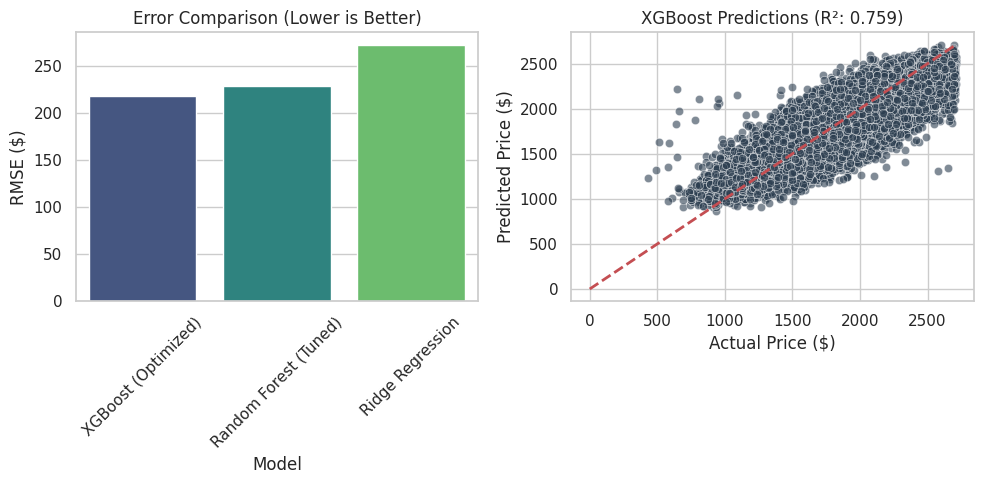

In [17]:
# ==========================================
# 4. FINAL LEADERBOARD
# ==========================================
df_results = pd.DataFrame(model_performance).sort_values(by='RMSE')

print("\n=== FINAL RESULTS TABLE ===")
print(df_results)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', data=df_results, palette='viridis')
plt.title('Error Comparison (Lower is Better)')
plt.ylabel('RMSE ($)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
y_true_dollar = np.exp(y_test)
sns.scatterplot(x=y_true_dollar, y=y_pred_xgb, alpha=0.6, color='#2c3e50')
plt.plot([0, y_true_dollar.max()], [0, y_true_dollar.max()], 'r--', lw=2)
plt.title(f'XGBoost Predictions (R²: {df_results.iloc[0]["R2"]:.3f})')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')

plt.tight_layout()
plt.show()


=== FINAL VISUAL ANALYSIS ===


/tmp/ipython-input-1804967294.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')


Text(0.5, 1.0, 'Top 10 Features Driving Price')

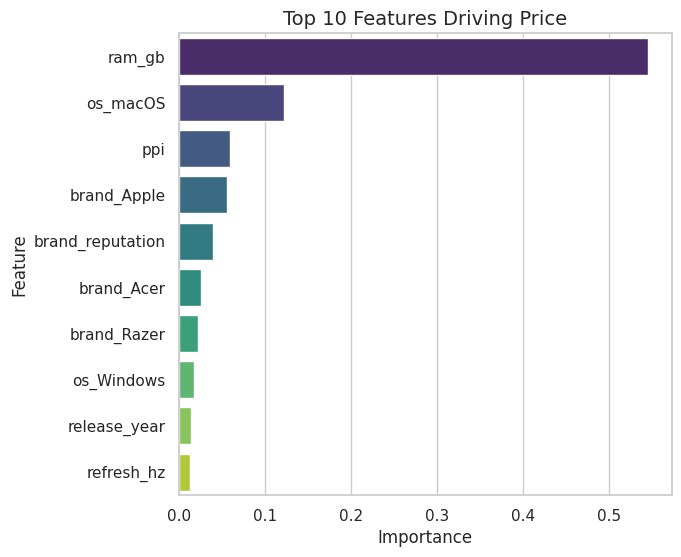

In [18]:
# ==========================================
# 6. FINAL VISUALIZATION (ERROR ANALYSIS)
# ==========================================
print("\n=== FINAL VISUAL ANALYSIS ===")
y_test_actual = np.exp(y_test)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_final.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')
plt.title('Top 10 Features Driving Price', fontsize=14)



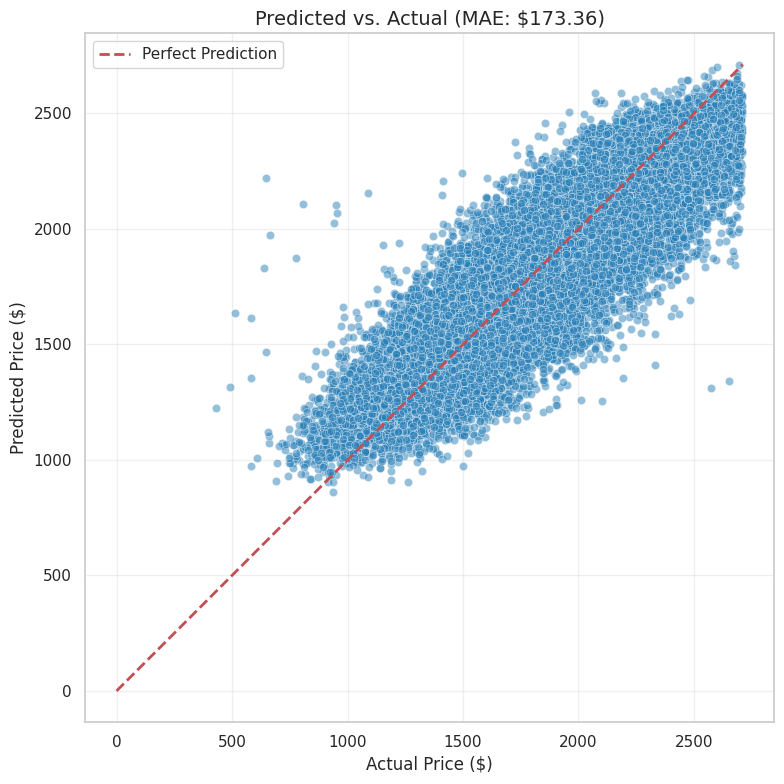


--- LEADERBOARD ---
                   Model         MAE        RMSE        R2
3    XGBoost (Optimized)  173.356294  218.354988  0.758574
2    XGBoost (Optimized)  173.403486  218.470376  0.758319
1  Random Forest (Tuned)  181.171128  228.614178  0.735355
0       Ridge Regression  214.433926  272.593683  0.623739


In [19]:
from sklearn.metrics import mean_absolute_error

y_test_actual = np.exp(y_test)
y_pred_final = y_pred_xgb

mae = mean_absolute_error(y_test_actual, y_pred_final)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_actual, y=y_pred_final, alpha=0.5, color='#2980b9')

max_val = max(y_test_actual.max(), y_pred_final.max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title(f'Predicted vs. Actual (MAE: ${mae:.2f})', fontsize=14)

plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n--- LEADERBOARD ---")
print(pd.DataFrame(model_performance).sort_values(by='RMSE'))

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.base import clone

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
print(f"Starting Cross-Validation on {len(X_train)} samples...")
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):

    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    model = clone(xgb_final)

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    print(f"Fold {fold+1}: RMSE = {rmse:.4f}, R2 = {r2:.4f}, Trees = {model.best_iteration}")
print("\n--- Cross-Validation Results ---")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Mean R2:   {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

Starting Cross-Validation on 71553 samples...
Fold 1: RMSE = 0.1305, R2 = 0.7497, Trees = 226
Fold 2: RMSE = 0.1310, R2 = 0.7508, Trees = 223
Fold 3: RMSE = 0.1328, R2 = 0.7450, Trees = 229
Fold 4: RMSE = 0.1320, R2 = 0.7504, Trees = 260
Fold 5: RMSE = 0.1304, R2 = 0.7474, Trees = 216

--- Cross-Validation Results ---
Mean RMSE: 0.1313 ± 0.0009
Mean R2:   0.7486 ± 0.0022


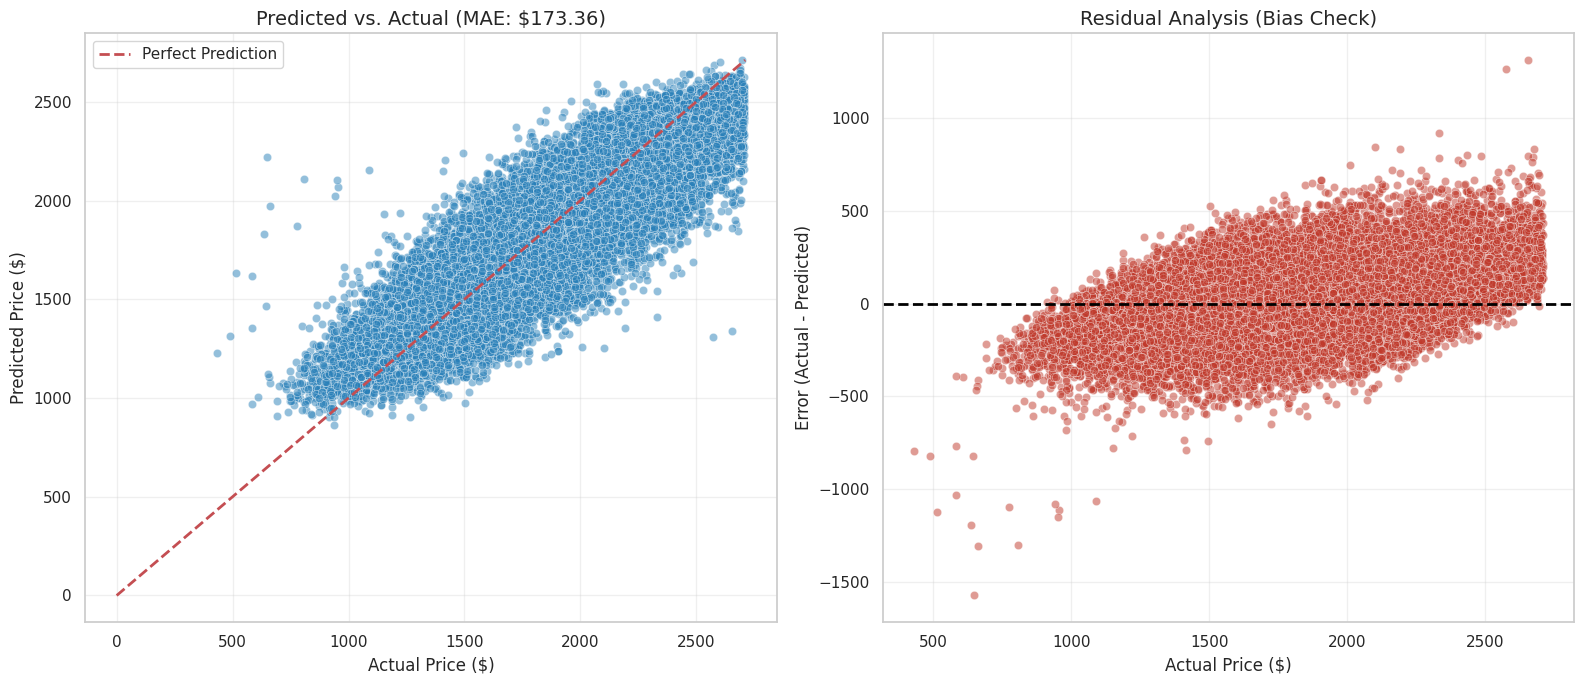

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test_actual - y_pred_final

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.scatterplot(x=y_test_actual, y=y_pred_final, alpha=0.5, color='#2980b9', ax=axes[0])
max_val = max(y_test_actual.max(), y_pred_final.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_title(f'Predicted vs. Actual (MAE: ${mae:.2f})', fontsize=14)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

sns.scatterplot(x=y_test_actual, y=residuals, alpha=0.5, color='#c0392b', ax=axes[1])
axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_title('Residual Analysis (Bias Check)', fontsize=14)
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Error (Actual - Predicted)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()